In [1]:
from logging import WARNING
from fenics import *
import numpy as np
from vedo.dolfin import plot, Latex, clear, histogram
import matplotlib.pyplot as plt
import pickle 
import matplotlib.pyplot as plt
from fenics import *
import warnings
import logging
import time
import statsmodels.api as sm


embedWindow(verbose=True): could not load ipyvtklink try:
> pip install ipyvtklink


In [2]:
def mcmc_diagnosis_plots(mcmc_chain, mcmc_acceptance_ratio, burn_in_period, lag, file_name):

    # Cut off the burning part
    l = len(mcmc_chain)
    burn = int(burn_in_period*l)
    ind_ = list(range(l))
    burn_ind, alpha_ind = ind_[:burn+1], ind_[burn:]
    burn_dt, alpha_dt = mcmc_chain[:burn+1], mcmc_chain[burn:]

    # calculate autocorrelations
    acf = sm.tsa.acf(mcmc_chain, nlags=lag)
    laglist = list(range(len(acf)))

    # Create a trace and distribution plots of the estimated parameter
    ax[0,0].plot(burn_ind, burn_dt, 'r-', label=r'Burn-in period')
    ax[0,0].plot(alpha_ind, alpha_dt, 'b-', label=r'After burn-in')
    ax[0,0].set_xlabel('$k$')
    ax[0,0].set_ylabel(r'$ \alpha $')
    ax[0,0].set_title(r'Trace plot of $\alpha$ before and after the burn-in period')
    ax[0,0].legend()

    sns.histplot(alpha_dt, kde=True, stat="probability", ax=ax[0,1])
    ax[0,1].set_xlabel(r'$ \alpha $')
    ax[0,1].set_title(r'Distribution plot of $ \alpha $ after the burn-in period')
    
    ax[1,0].plot(range(0, len(mcmc_acceptance_ratio)), mcmc_acceptance_ratio)
    ax[1,0].set_xlabel('$k$')
    ax[1,0].set_ylabel(r'$|X_{accept}|/|X_{total}|$')
    ax[1,0].set_title(r'Ratio of accepted state to the total number of states')

    ax[1,1].plot(laglist, acf)
    ax[1,1].set_xlabel(r'lags $(k)$')
    ax[1,1].set_ylabel(r'$ACF$')
    ax[1,1].set_title(r'Autocorrelation plot')

    plt.savefig(fname=file_name, format='png')

    plt.show()

In [3]:
def compare_two_chains(mcmcchain_rw_cellaveraging,mcmcchain_rw_interpolating,accratios_rw_interpolating,accratios_rw_cellaveraging,name_title):
    
    ## Define the burn in period 
    burnin=200

    ## Plot results of interest 
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))

    ## Compare two chains
    burnin=200
    ax[0,0].plot(mcmcchain_rw_cellaveraging[burnin::],label = "Random Walk - Cell averaging")
    ax[0,0].plot(mcmcchain_rw_interpolating[burnin::], label = "Random Walk - Interpolating")
    ax[0,0].set_ylabel("Value of alpha")
    ax[0,0].set_xlabel("Number of iterations")
    ax[0,0].legend()

    ## Plot the two histograms
    # Cell averaging
    bins = np.linspace(-3., 3., 100) #set bins to plot an histogram of the values of X^0
    step = bins[1]-bins[0] #adjust the setp 
    hist,bin_edges = np.histogram(mcmcchain_rw_cellaveraging, bins=bins,density=True) #get the histogram
    hist_norm = hist/(sum(hist)*step) # normalise the histogram
    ax[0,1].bar(bin_edges[:-1], hist_norm, width = step, alpha = 0.5,label="Cell averaging") # plot the histogram
    # Cell interpolating
    bins = np.linspace(-1., 1., 100) #set bins to plot an histogram of the values of X^0
    step = bins[1]-bins[0] #adjust the setp 
    hist,bin_edges = np.histogram(mcmcchain_rw_interpolating, bins=bins,density=True) #get the histogram
    hist_norm = hist/(sum(hist)*step) # normalise the histogram
    ax[0,1].bar(bin_edges[:-1], hist_norm, width = step, alpha = 0.5,label="Interpolating") # plot the histogram
    ax[0,1].legend()
    ax[0,1].set_ylabel("Histogram of alpha")

    ## Plot the autocorrelation function 
    lag = 50
    # Cell averaging
    acf = sm.tsa.acf(mcmcchain_rw_cellaveraging, nlags=lag)
    ax[1,0].plot(acf, label="Cell averaging")
    # Cell interpolating
    acf = sm.tsa.acf(mcmcchain_rw_interpolating, nlags=lag)
    ax[1,0].plot(acf,label="Interpolating")
    ax[1,0].legend()
    ax[1,0].set_ylabel("Autocorrelation")

    ## Plot acceptance ratios 
    ax[1,1].plot(accratios_rw_interpolating,label="Interpolating")
    ax[1,1].plot(accratios_rw_cellaveraging,label="Cell averaging")
    ax[1,1].set_ylabel("acceptance ratio")
    
    fig.suptitle(name_title)


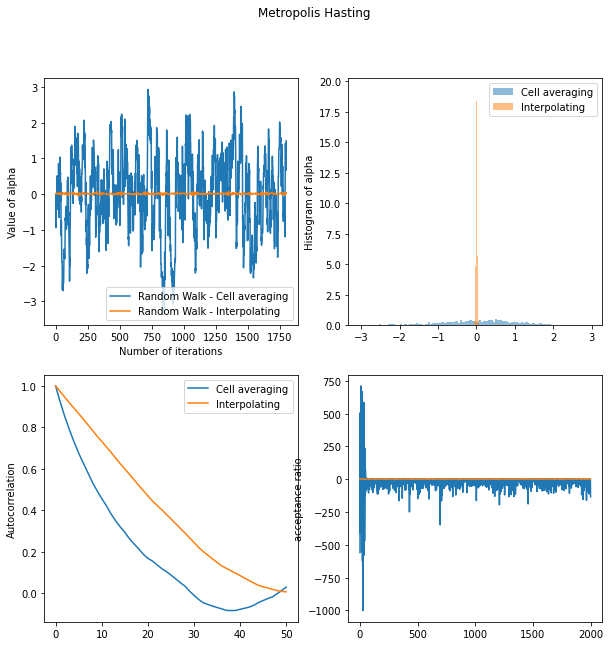

In [4]:
### METROPOLIS HASTING

## Get data on cell averaging results 
name_file = "data/chains/var_metropolis.npy"
mcmcchain_rw_cellaveraging = np.load(name_file)

name_file = "data/chains/var_metropolis_accept_ratio.npy"
accratios_rw_cellaveraging = np.load(name_file)

## Get data on interpolating results
name_file = "data/Sleepy_Data/alpha_list_RWMH"
with open(name_file, 'rb') as f:
    mcmcchain_rw_interpolating = pickle.load(f)
    
name_file = "data/Sleepy_Data/A_list_RWMH"
with open(name_file, 'rb') as f:
    accratios_rw_interpolating = pickle.load(f)
 
compare_two_chains(mcmcchain_rw_cellaveraging,mcmcchain_rw_interpolating,accratios_rw_interpolating,accratios_rw_cellaveraging,"Metropolis Hasting")


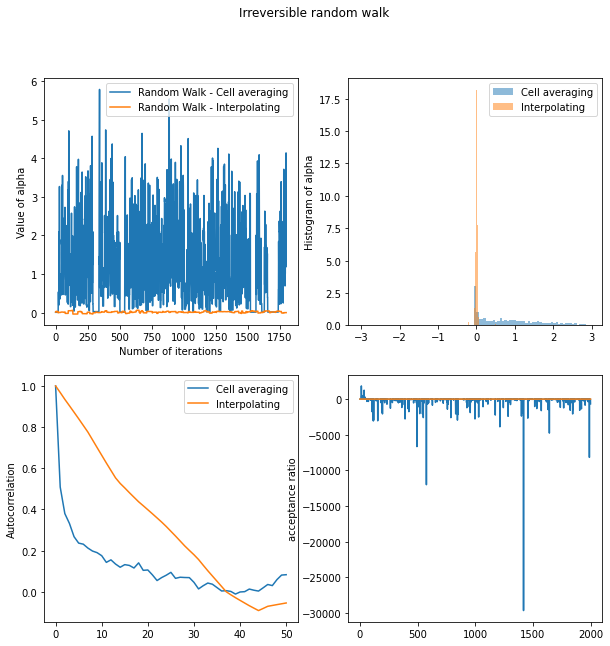

In [5]:
### IRREVERSIBLE RANDOM WALK

## Get data on cell averaging results 
name_file = "data/Non-reversible/gamma_nonreversible_MCMC.npy"
mcmcchain_rw_cellaveraging = np.load(name_file)

name_file = "data/Non-reversible/gamma_nonreversible_MCMC_accept_ratio.npy"
accratios_rw_cellaveraging = np.load(name_file)

## Get data on interpolating results
name_file = "data/Sleepy_Data/alpha_list_IRWMH"
with open(name_file, 'rb') as f:
    mcmcchain_rw_interpolating = pickle.load(f)
    
name_file = "data/Sleepy_Data/A_list_IRWMH"
with open(name_file, 'rb') as f:
    accratios_rw_interpolating = pickle.load(f)

compare_two_chains(mcmcchain_rw_cellaveraging,mcmcchain_rw_interpolating,accratios_rw_interpolating,accratios_rw_cellaveraging,"Irreversible random walk")


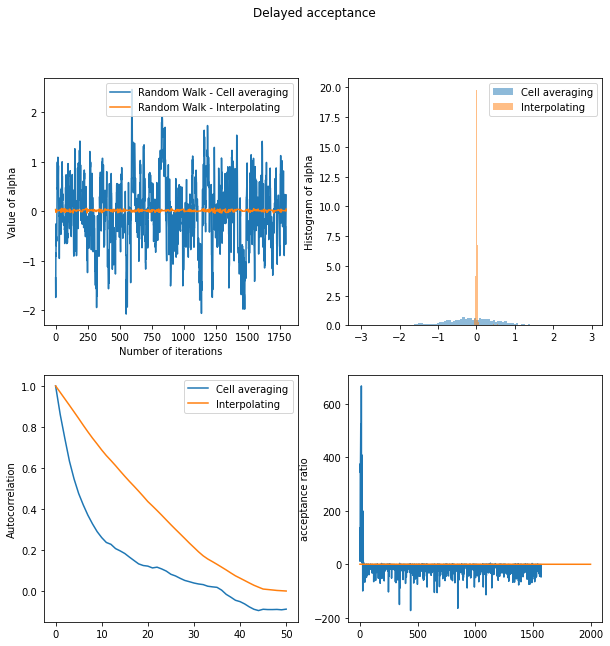

In [6]:
### Delayed acceptance

## Get data on cell averaging results 
name_file = "data/chains/var_delayed_MCMC.npy"
mcmcchain_rw_cellaveraging = np.load(name_file)

name_file = "data/chains/var_delayed_MCMC_accept_ratio.npy"
accratios_rw_cellaveraging = np.load(name_file)

## Get data on interpolating results
name_file = "data/Sleepy_Data/alpha_list_DA"
with open(name_file, 'rb') as f:
    mcmcchain_rw_interpolating = pickle.load(f)
    
name_file = "data/Sleepy_Data/A_list_DA"
with open(name_file, 'rb') as f:
    accratios_rw_interpolating = pickle.load(f)

compare_two_chains(mcmcchain_rw_cellaveraging,mcmcchain_rw_interpolating,accratios_rw_interpolating,accratios_rw_cellaveraging,"Delayed acceptance")
